<a href="https://colab.research.google.com/github/omakaroshka/Makarevich-OV/blob/main/VKR_Makarevich_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# импорт библиотек

In [1]:
# импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as stats
import sklearn.linear_model as lm
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler, OrdinalEncoder

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
import pickle


In [2]:
# Импорт библиотеки TensorFlow
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.12.0


# модель для прогноза модуля упругости при растяжении

⦁ Обучить нескольких моделей для прогноза модуля упругости при растяжении и прочности при растяжении. При построении модели необходимо 30% данных оставить на тестирование модели, на остальных происходит обучение моделей. При построении моделей провести поиск гиперпараметров модели с помощью поиска по сетке с перекрестной проверкой, количество блоков равно 10

In [3]:
!gdown --id  1ee_9iNqrYziOGMaV94z2jhWmkOHYq9Wt
df= pd.read_excel('makarevich.xlsx', index_col=0)

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ee_9iNqrYziOGMaV94z2jhWmkOHYq9Wt
To: /content/makarevich.xlsx
100% 156k/156k [00:00<00:00, 13.8MB/s]


In [4]:
!gdown --id  1YLFOLKeMF7hBov_E1YfMeBc2gWBFpM56
df_minmaxscaler= pd.read_csv('makarevich_minmaxscaler.csv', index_col=0)

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1YLFOLKeMF7hBov_E1YfMeBc2gWBFpM56
To: /content/makarevich_minmaxscaler.csv
100% 220k/220k [00:00<00:00, 88.8MB/s]


Разделить данные на входные и выходные признаки

In [5]:
#from IPython.display import Image
#Image(filename='composit.png')

In [6]:
# Признаки для Модуль упругости при растяжении
y1_columns = ['Модуль упругости при растяжении, ГПа']
X1_columns = [
  'Соотношение матрица-наполнитель', 
  'Плотность, кг/м3',
  'модуль упругости, ГПа', 
  'Количество отвердителя, м.%',
  'Содержание эпоксидных групп,%_2', 
  'Температура вспышки, С_2',
  'Поверхностная плотность, г/м2', 
  'Потребление смолы, г/м2',
  'Угол нашивки', 
  'Шаг нашивки', 
  'Плотность нашивки'
]

In [7]:
y1 = df.loc[:, y1_columns]
X1 = df.loc[:, X1_columns]

In [8]:
# Разделю переменные на категориальные и численные
X_categorical = ['Угол нашивки']
X1_continuous = [column for column in X1_columns if column not in X_categorical]

In [9]:
# Препроцессор для задачи Модуль упругости при растяжении
preprocessor1 = ColumnTransformer(transformers=[
        ("continuous", MinMaxScaler(), X1_continuous),
        ("categorical", OrdinalEncoder(), X_categorical)
])

In [10]:
# Необходимо сравнить распределения признаков до и после обработки

Нужно попробовать разные. Для сравнения моделей использую несколько метрик. Для статистической устойчивости результатов использую кросс-валидацию. Оформлю запуск моделей, кросс-валидацию и получение метрик в виде вспомогательной функции.

In [11]:
def run_models(models, X, y):
    stat = pd.DataFrame()
    cv = KFold(10, shuffle=True, random_state=0)
    scoring = ['r2', 
                'max_error', 
                'neg_root_mean_squared_error', 
                'neg_mean_absolute_error', 
                'neg_mean_absolute_percentage_error']
    for model_name, model in models.items():
        scores = cross_validate(model, X, y, cv=cv, scoring=scoring)
        stat.loc[model_name, 'R2'] = scores['test_r2'].mean()
        stat.loc[model_name, 'RMSE'] = scores['test_neg_root_mean_squared_error'].mean()
        stat.loc[model_name, 'MAE'] = scores['test_neg_mean_absolute_error'].mean()
        stat.loc[model_name, 'MAPE'] = scores['test_neg_mean_absolute_percentage_error'].mean()
        stat.loc[model_name, 'max_error'] = scores['test_max_error'].mean()
    return stat

Для поиска параметров по сетке тоже сделаю вспомогательную функцию, чтобы везде использовалась одинаковые параметры и одинаково выводился результат.

In [12]:
def run_grid_search(model, params, X, y):
    pd.options.display.max_colwidth = 200
    stat = pd.DataFrame()
    cv = KFold(10, shuffle=True, random_state=0)
    # scoring = 'neg_root_mean_squared_error'
    scoring = 'neg_mean_absolute_error'
    searcher = GridSearchCV(model, params, cv=cv, scoring=scoring)
    searcher.fit(X, y)
    stat.loc[:, 'params'] = searcher.cv_results_['params']
    stat.loc[:, 'MAE'] = searcher.cv_results_['mean_test_score']
    stat.loc[:, 'rank'] = searcher.cv_results_['rank_test_score']
    return stat, searcher.best_estimator_

И еще одна вспомогательная функция для получения метрик предсказания.

In [13]:
def get_metrics(model_name, y, y_pred):
    stat = pd.DataFrame()
    stat.loc[model_name, 'R2'] = metrics.r2_score(y, y_pred)
    stat.loc[model_name, 'RMSE'] = metrics.mean_squared_error(y, y_pred, squared=False) * -1
    stat.loc[model_name, 'MAE'] = metrics.mean_absolute_error(y, y_pred) * -1
    stat.loc[model_name, 'MAPE'] = metrics.mean_absolute_percentage_error(y, y_pred) * -1
    stat.loc[model_name, 'max_error'] = metrics.max_error(y, y_pred) * -1
    return stat

Чтобы определить нижнюю границу качества модели, использую базовую модель, возвращающую среднее значение целевого признака. Рабочая модель по своим характеристикам должна быть лучше базовой. Можно для этой цели создать класс, унаследованный от BaseEstimator. А можно использовать DummyRegressor из sklearn.

In [14]:
# Разделяю на тренировочную и тестовую выборку
X1_train_raw, X1_test_raw, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=0)
print('X1_train:', X1_train_raw.shape, 'y1_train:', y1_train.shape)
print('X1_test:', X1_test_raw.shape, 'y1_test:', y1_test.shape)

X1_train: (645, 11) y1_train: (645, 1)
X1_test: (277, 11) y1_test: (277, 1)


In [15]:
# Выполняю препроцессинг входных переменных
X1_train = preprocessor1.fit_transform(X1_train_raw)
X1_test = preprocessor1.transform(X1_test_raw)

In [16]:
# Выходная переменная преобразованиям не подвергается
y1_train = y1_train['Модуль упругости при растяжении, ГПа'].values
y1_test = y1_test['Модуль упругости при растяжении, ГПа'].values

In [17]:
# Описательная статистика входных данных до предобработки
X1_train_raw.describe(include='all').loc[['min', 'max', 'mean', 'std'], :].T

,min,max,mean,std
Соотношение матрица-наполнитель,0.547391,5.295842,2.923819,0.913231
"Плотность, кг/м3",1784.482245,2161.565216,1975.182545,70.834635
"модуль упругости, ГПа",9.986210,1628.000000,740.862235,331.025855
"Количество отвердителя, м.%",38.668500,181.828448,111.166916,27.119431
"Содержание эпоксидных групп,%_2",16.048978,28.955094,22.219115,2.390374
"Температура вспышки, С_2",179.374391,386.067992,287.176220,38.701232
"Поверхностная плотность, г/м2",0.603740,1291.340115,476.244925,275.408454
"Потребление смолы, г/м2",74.097866,359.052220,218.054482,55.615498
Угол нашивки,0.000000,1.000000,0.516279,0.500123
Шаг нашивки,0.239660,13.732404,6.925247,2.531077


In [18]:
# Описательная статистика входных данных после предобработки

pd.DataFrame(X1_train, columns=(X1_continuous + X_categorical)).describe().loc[['min', 'max', 'mean', 'std'], :].T

,min,max,mean,std
Соотношение матрица-наполнитель,0.0,1.0,0.500464,0.192322
"Плотность, кг/м3",0.0,1.0,0.505725,0.187849
"модуль упругости, ГПа",0.0,1.0,0.451712,0.204588
"Количество отвердителя, м.%",0.0,1.0,0.506415,0.189434
"Содержание эпоксидных групп,%_2",0.0,1.0,0.478079,0.185213
"Температура вспышки, С_2",0.0,1.0,0.521554,0.187240
"Поверхностная плотность, г/м2",0.0,1.0,0.368504,0.213373
"Потребление смолы, г/м2",0.0,1.0,0.505192,0.195173
Шаг нашивки,0.0,1.0,0.495495,0.187588
Плотность нашивки,0.0,1.0,0.501404,0.195642


In [19]:
pd.DataFrame(y1_train, columns=y1_columns).describe().loc[['min', 'max', 'mean', 'std'], :].T

,min,max,mean,std
"Модуль упругости при растяжении, ГПа",65.793845,81.203147,73.317881,3.02202


In [20]:
# Сравнение моделей с параметрами по умолчанию
def_models1 = {
    'DummyRegressor': DummyRegressor(strategy='mean'),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'SVR': SVR(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=0),
    'RandomForestRegressor': RandomForestRegressor(random_state=0)
}

stat1_1 = run_models(def_models1, X1_train, y1_train)
stat1_1.style.highlight_max(axis=0)

,R2,RMSE,MAE,MAPE,max_error
DummyRegressor,-0.026057,-3.014109,-2.424899,-0.033131,-7.283927
LinearRegression,-0.047874,-3.042918,-2.450669,-0.033479,-7.588069
Ridge,-0.045967,-3.040387,-2.448812,-0.033454,-7.572405
Lasso,-0.026057,-3.014109,-2.424899,-0.033131,-7.283927
SVR,-0.096152,-3.110400,-2.488166,-0.033943,-8.123389
KNeighborsRegressor,-0.281332,-3.353022,-2.686900,-0.036650,-8.869263
DecisionTreeRegressor,-1.245641,-4.404079,-3.554616,-0.048538,-10.781219
RandomForestRegressor,-0.101241,-3.117089,-2.497387,-0.034130,-7.742759


Коэффициент детерминации R2 близок к 0 для линейных моделей и метода опорных векторов. Значит, они не лучше базовой модели. И остальные метрики у них примерно совпадают с базовой моделью.

Гораздо хуже линейных с гиперпараметрами по умолчанию отработали метод ближайших соседей и деревья решений.

Случайный лес отработал лучше, чем одно дерево решений, но хуже, чем линейные модели.

In [21]:
# Приступаем к поиску лучших моделей
s_models1 = {}

In [22]:
# Попробую подобрать параметры для модели Ridge
#
# alpha, default=1.0
# Regularization strength; must be a positive float
#
# solver {‘auto’, ‘svd’, ‘cholesky’, ‘lsqr’, ‘sparse_cg’, ‘sag’, ‘saga’, ‘lbfgs’}, default=’auto’
# Solver to use in the computational routines
#
# random_state - только для ‘sag’, ‘saga’
#
# positive - только для ‘lbfgs’

In [23]:
params1 = [
  {
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'],
    'alpha': range(10, 1510, 10)
  },           
  {
    'solver': ['lbfgs'],
    'alpha': range(10, 1510, 10),
    'positive': [True]
  }
]
search, smodel = run_grid_search(Ridge(), params1, X1_train, y1_train)
s_models1[str(smodel)] = smodel
search[search['rank']==1]

,params,MAE,rank
774,"{'alpha': 250, 'positive': True, 'solver': 'lbfgs'}",-2.423876,1


In [24]:
# Попробую подобрать параметры для модели Lasso
#
# alpha, default=1.0
# Constant that multiplies the L1 term. 

In [25]:
params1 = [
  {
    'alpha': [0.001, 0.005, 0.01, 0.05, 0.095, 0.1, 0.150, 0.2, 0.5, 1]
  }
]
search, smodel = run_grid_search(Lasso(), params1, X1_train, y1_train)
s_models1[str(smodel)] = smodel
search[search['rank']==1]

,params,MAE,rank
6,{'alpha': 0.15},-2.424899,1
7,{'alpha': 0.2},-2.424899,1
8,{'alpha': 0.5},-2.424899,1
9,{'alpha': 1},-2.424899,1


In [26]:
# Попробую подобрать параметры для модели SVR
#
# kernel {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’}
#
# Остальные параметры подходят для разных ядер
#
# C, default=1.0
# Regularization parameter

In [27]:
params1 = [
    {
      'kernel': ['linear'],
      'C': [0.001, 0.005, 0.01, 0.015, 0.02, 0.03]
    },
    {
      'kernel': ['poly'],
      'C': [0.001, 0.01, 0.02]
    },
    {
      'kernel': ['rbf'],
      'C': [0.01, 0.02, 0.03, 0.04]
    },
    {
      'kernel': ['sigmoid'],
      'C': [0.01, 0.02, 0.03, 0.04, 0.5]
    }
]
search, smodel = run_grid_search(SVR(), params1, X1_train, y1_train)
s_models1[str(smodel)] = smodel
search[search['rank']==1]

,params,MAE,rank
11,"{'C': 0.03, 'kernel': 'rbf'}",-2.423142,1


In [28]:
# Попробую подобрать параметры для KNeighborsRegressor
#
# n_neighbors, default=5
# Number of neighbors to use by default for kneighbors queries.

In [29]:
params1 = {
    'n_neighbors': range(3, 31, 2)
}
search, smodel = run_grid_search(KNeighborsRegressor(), params1, X1_train, y1_train)
s_models1[str(smodel)] = smodel
search[search['rank']==1]

,params,MAE,rank
12,{'n_neighbors': 27},-2.454858,1


In [30]:
# Попробую подобрать параметры для DecisionTreeRegressor
#
# criterion {“squared_error”, “friedman_mse”, “absolute_error”, “poisson”}
# The function to measure the quality of a split.
#
# splitter{“best”, “random”}
#
# max_depth
# The maximum depth of the tree
#
# max_features
# The number of features to consider when looking for the best split

In [31]:
params1 = {
    'random_state': [0],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'splitter': ['best', 'random'],
    'max_depth': [1, 2, 3],
    'max_features': range(1, 11, 1)
}
search, smodel = run_grid_search(DecisionTreeRegressor(), params1, X1_train, y1_train)
s_models1[str(smodel)] = smodel
search[search['rank']==1]

,params,MAE,rank
31,"{'criterion': 'squared_error', 'max_depth': 2, 'max_features': 6, 'random_state': 0, 'splitter': 'random'}",-2.418936,1
91,"{'criterion': 'friedman_mse', 'max_depth': 2, 'max_features': 6, 'random_state': 0, 'splitter': 'random'}",-2.418936,1
211,"{'criterion': 'poisson', 'max_depth': 2, 'max_features': 6, 'random_state': 0, 'splitter': 'random'}",-2.418936,1


In [32]:
# Попробую подобрать параметры для RandomForestRegressor
#
# n_estimators
# The number of trees in the forest.
#
# criterion {“squared_error”, “absolute_error”, “poisson”}
# The function to measure the quality of a split
#
# max_depth
# The maximum depth of the tree
#
# max_features
# The number of features to consider when looking for the best split
#
# bootstrap
# Whether bootstrap samples are used when building trees

In [33]:
params1 = {
    'random_state': [0],
    'n_estimators': [50, 100], 
    'criterion': ['absolute_error'],
    'max_depth': [2, 3, 4, 5],
    'max_features': [1, 2, 11],
    'bootstrap': [False]
}
search, smodel = run_grid_search(RandomForestRegressor(), params1, X1_train, y1_train)
s_models1[str(smodel)] = smodel
search[search['rank']==10]

,params,MAE,rank
2,"{'bootstrap': False, 'criterion': 'absolute_error', 'max_depth': 2, 'max_features': 2, 'n_estimators': 50, 'random_state': 0}",-2.453473,10


In [34]:
# Сравнение моделей с подобранными параметрами, поиск лучшей
stat1_2 = run_models(s_models1, X1_train, y1_train)
stat1_2.style.highlight_max(axis=0)

,R2,RMSE,MAE,MAPE,max_error
"Ridge(alpha=250, positive=True, solver='lbfgs')",-0.025156,-3.012657,-2.423876,-0.033116,-7.294961
Lasso(alpha=0.15),-0.026057,-3.014109,-2.424899,-0.033131,-7.283927
SVR(C=0.03),-0.025752,-3.013242,-2.423142,-0.033103,-7.353853
KNeighborsRegressor(n_neighbors=27),-0.063403,-3.061797,-2.454858,-0.033521,-7.840915
"DecisionTreeRegressor(max_depth=2, max_features=6, random_state=0, splitter='random')",-0.025845,-3.014766,-2.418936,-0.033039,-7.464686
"RandomForestRegressor(bootstrap=False, criterion='absolute_error', max_depth=2, max_features=1, random_state=0)",-0.038261,-3.031111,-2.442722,-0.033364,-7.383372


Можно сделать вывод, что подбирая гиперпараметры, можно значительно улучшить предсказание выбранной модели.

Все модели крайне плохо описывают исходные данные - не удалось добиться положительного значения R2. Самый лучший результат дает коэффициент детерминации близкий к нулю, что соответствует базовой модели.

Линейные модели так и остались сравнимы с базовой моделью. Их характеристики улучшились, но не значительно.

Метод опорных векторов в процессе подбора гиперпараметры лучшим ядром выбрал линейное и отработал аналогично линейным моделям, получил очень близкие метрики.

Метод ближайших соседей увеличением количества соседей радикально улучшил качество работы. Но его лучшие результаты все равно немного, но отстают от линейных моделей.

Деревья решений при кропотливом подборе параметров превзошли результат линейной модели. Но они по-прежнему не являются объясняющей зависимость моделью.

Собирая деревья в ансамбли, можно еще улучшить характеристики. Но подбор параметров затруднен тем, что это затратный по времени процесс. Почему-то мне не удалось получить комбинацию параметров для леса, которая была был лучше дерева решений.

In [35]:
# Предсказание базовой модели
base_model1 = DummyRegressor(strategy='mean')
base_model1.fit(X1_train, y1_train)
y1_pred_base = base_model1.predict(X1_test)

In [36]:
# Предсказание лучшей модели
best_model1 = DecisionTreeRegressor(criterion='absolute_error', max_depth=2, max_features=10, random_state=0, splitter='random')
best_model1.fit(X1_train, y1_train)
y1_pred_best = best_model1.predict(X1_test)

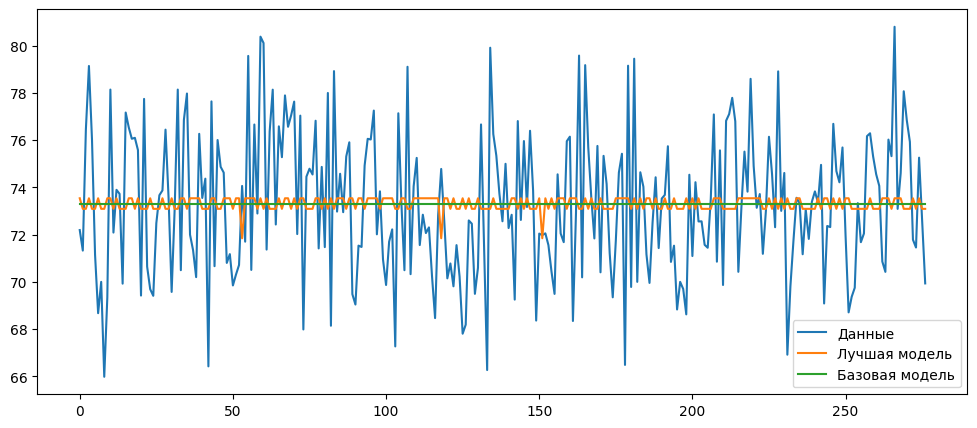

In [37]:
# Визуализация
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(y1_test, label='Данные')
ax.plot(y1_pred_best, label='Лучшая модель')
ax.plot(y1_pred_base, label='Базовая модель')
ax.legend()
plt.show()

In [38]:
# Сравнение предсказаний базовой модели и лучшей модели на тестовом множестве
compare1 = get_metrics('Базовая модель', y1_test, y1_pred_base)
compare1 = compare1.append(get_metrics('Лучшая модель (дерево решений)', y1_test, y1_pred_best))
compare1

<ipython-input-38-6daa562fd97f>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare1 = compare1.append(get_metrics('Лучшая модель (дерево решений)', y1_test, y1_pred_best))


,R2,RMSE,MAE,MAPE,max_error
Базовая модель,-0.000250,-3.034896,-2.514699,-0.034363,-7.485341
Лучшая модель (дерево решений),-0.016751,-3.059827,-2.551374,-0.034859,-7.262826


# Модель для прочности при растяжении

In [39]:
# Признаки для Прочность при растяжении
y2_columns = ['Прочность при растяжении, МПа']
X2_columns = [
  'Соотношение матрица-наполнитель', 
  'Плотность, кг/м3',
  'модуль упругости, ГПа', 
  'Количество отвердителя, м.%',
  'Содержание эпоксидных групп,%_2', 
  'Температура вспышки, С_2',
  'Поверхностная плотность, г/м2', 
  'Потребление смолы, г/м2',
  'Угол нашивки', 
  'Шаг нашивки', 
  'Плотность нашивки'
]

In [40]:
y2 = df.loc[:, y2_columns]
X2 = df.loc[:, X2_columns]

In [41]:
# Разделю переменные на категориальные и численные
X_categorical = ['Угол нашивки']
X2_continuous = [column for column in X2_columns if column not in X_categorical]

In [42]:
# Препроцессор для задачи Прочность при растяжении
preprocessor2 = ColumnTransformer(transformers=[
        ("continuous", MinMaxScaler(), X2_continuous),
        ("categorical", OrdinalEncoder(), X_categorical)
])

In [43]:
# Разделяем на тренировочную и тестовую выборку
X2_train_raw, X2_test_raw, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=0)
print('X2_train:', X2_train_raw.shape, 'y2_train:', y2_train.shape)
print('X2_test:', X2_test_raw.shape, 'y2_test:', y2_test.shape)

X2_train: (645, 11) y2_train: (645, 1)
X2_test: (277, 11) y2_test: (277, 1)


In [44]:
# Выполняю препроцессинг входных переменных
X2_test = preprocessor2.fit_transform(X2_test_raw)
X2_train = preprocessor2.transform(X2_train_raw)

In [45]:
# Выходная переменная преобразованиям не подвергается
y2_train = y2_train['Прочность при растяжении, МПа'].values
y2_test = y2_test['Прочность при растяжении, МПа'].values

In [46]:
# Описательная статистика входных данных до предобработки
X2_train_raw.describe()

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Потребление смолы, г/м2",Угол нашивки,Шаг нашивки,Плотность нашивки
count,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000
mean,2.923819,1975.182545,740.862235,111.166916,22.219115,287.176220,476.244925,218.054482,0.516279,6.925247,57.417577
std,0.913231,70.834635,331.025855,27.119431,2.390374,38.701232,275.408454,55.615498,0.500123,2.531077,11.220197
min,0.547391,1784.482245,9.986210,38.668500,16.048978,179.374391,0.603740,74.097866,0.000000,0.239660,28.661632
25%,2.284560,1926.383136,498.596429,93.292529,20.621846,261.702487,253.914554,180.548421,0.000000,5.076483,50.219836
50%,2.895477,1977.586290,734.164679,111.528183,22.178914,287.281300,450.429300,216.639017,1.000000,6.999222,57.341920
75%,3.540806,2020.947411,962.774186,130.477891,23.967543,314.462314,692.271085,257.147389,1.000000,8.650571,64.619238
max,5.295842,2161.565216,1628.000000,181.828448,28.955094,386.067992,1291.340115,359.052220,1.000000,13.732404,86.012427


In [47]:
# Описательная статистика входных данных после предобработки
pd.DataFrame(X2_train, columns=(X2_continuous + X_categorical)).describe()


,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Потребление смолы, г/м2",Шаг нашивки,Плотность нашивки,Угол нашивки
count,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000
mean,0.493292,0.471238,0.457893,0.482836,0.493750,0.501212,0.365100,0.511695,0.523320,0.506951,0.516279
std,0.193589,0.202658,0.205267,0.204810,0.180930,0.195543,0.215222,0.195557,0.192311,0.207077,0.500123
min,-0.010470,-0.074354,0.004681,-0.064684,0.026725,-0.043471,-0.006598,0.005510,0.015350,-0.023761,0.000000
25%,0.357780,0.331623,0.307665,0.347846,0.372851,0.372503,0.191356,0.379815,0.382851,0.374112,0.000000
50%,0.487284,0.478115,0.453740,0.485564,0.490708,0.501743,0.344926,0.506718,0.528941,0.505555,1.000000
75%,0.624083,0.602171,0.595499,0.628675,0.626091,0.639078,0.533917,0.649155,0.654410,0.639863,1.000000
max,0.996120,1.004478,1.008001,1.016482,1.003605,1.000875,1.002070,1.007476,1.040528,1.034690,1.000000


In [48]:
# Описательная статистика выходной переменной
pd.DataFrame(y2_train, columns=(y2_columns)).describe()

,"Прочность при растяжении, МПа"
count,645.000000
mean,2468.588984
std,457.780713
min,1250.392802
25%,2160.577394
50%,2461.455107
75%,2754.515879
max,3636.892992


In [49]:
# Запускаю различные модели с параметрами по умолчанию
models2_def = {
    'DummyRegressor': DummyRegressor(strategy='mean'),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'SVR': SVR(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=0),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=0)    
}

stat2_1 = run_models(models2_def, X2_train, y2_train)
stat2_1.style.highlight_max(axis=0)

,R2,RMSE,MAE,MAPE,max_error
DummyRegressor,-0.017468,-456.122904,-365.102326,-0.158220,-1101.569801
LinearRegression,-0.048162,-462.477230,-370.627904,-0.160314,-1138.145458
Ridge,-0.046137,-462.063105,-370.293183,-0.160189,-1135.671404
Lasso,-0.044147,-461.697214,-369.849272,-0.160077,-1131.422133
SVR,-0.016121,-455.849127,-364.975222,-0.157742,-1098.846807
DecisionTreeRegressor,-1.167982,-659.877929,-532.226149,-0.226939,-1710.997601
GradientBoostingRegressor,-0.091772,-472.143039,-380.422947,-0.164054,-1166.127785


Ни одна из выбранных мной моделей не соответствует данным.

R2 близок к 0 для линейных моделей и метода опорных векторов. Значит, они не лучше базовой модели. И остальные метрики у них примерно совпадают с базовой моделью.

Гораздо хуже линейных с гиперпараметрами по умолчанию отработали деревья решений.

Градиентный бустинг с параметрами по умолчанию отработал лучше дерева, сравнимо с базовой моделью.

In [50]:
# Приступаем к поиску лучших моделей
s_models2 = {}

In [51]:
# Попробую подобрать параметры для модели Ridge
#
# alpha, default=1.0
# Regularization strength; must be a positive float
#
# solver {‘auto’, ‘svd’, ‘cholesky’, ‘lsqr’, ‘sparse_cg’, ‘sag’, ‘saga’, ‘lbfgs’}, default=’auto’
# Solver to use in the computational routines
#
# random_state - только для ‘sag’, ‘saga’
#
# positive - только для ‘lbfgs’

In [52]:
params2 = [
  {
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'],
    'alpha': range(10, 1000, 10)
  },
  {
    'solver': ['sag', 'saga'],
    'alpha': range(10, 1000, 10),
    'random_state': [0]
  },
  {
    'solver': ['lbfgs'],
    'alpha': range(10, 1000, 10),
    'positive': [True]
  }
]
search, smodel = run_grid_search(Ridge(), params2, X2_train, y2_train)
s_models2[str(smodel)] = smodel
search[search['rank']==1]

,params,MAE,rank
736,"{'alpha': 440, 'positive': True, 'solver': 'lbfgs'}",-365.114337,1
737,"{'alpha': 450, 'positive': True, 'solver': 'lbfgs'}",-365.114337,1
738,"{'alpha': 460, 'positive': True, 'solver': 'lbfgs'}",-365.114337,1
739,"{'alpha': 470, 'positive': True, 'solver': 'lbfgs'}",-365.114337,1
740,"{'alpha': 480, 'positive': True, 'solver': 'lbfgs'}",-365.114337,1
741,"{'alpha': 490, 'positive': True, 'solver': 'lbfgs'}",-365.114337,1
742,"{'alpha': 500, 'positive': True, 'solver': 'lbfgs'}",-365.114337,1
743,"{'alpha': 510, 'positive': True, 'solver': 'lbfgs'}",-365.114337,1
744,"{'alpha': 520, 'positive': True, 'solver': 'lbfgs'}",-365.114337,1
745,"{'alpha': 530, 'positive': True, 'solver': 'lbfgs'}",-365.114337,1


In [53]:
# Попробую подобрать параметры для модели Lasso
#
# alpha, default=1.0
# Constant that multiplies the L1 term. 

In [54]:
params2 = [
  {
    'alpha': [0.1, 1, 5, 10, 20, 30, 40, 50, 60, 100]
  }
]
search, smodel = run_grid_search(Lasso(), params2, X2_train, y2_train)
s_models2[str(smodel)] = smodel
search[search['rank']==1]

,params,MAE,rank
3,{'alpha': 10},-365.102326,1
4,{'alpha': 20},-365.102326,1
5,{'alpha': 30},-365.102326,1
6,{'alpha': 40},-365.102326,1
7,{'alpha': 50},-365.102326,1
8,{'alpha': 60},-365.102326,1
9,{'alpha': 100},-365.102326,1


In [55]:
# Попробую подобрать параметры для модели SVR
#
# kernel {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’}
#
# Остальные параметры подходят для разных ядер
#
# C, default=1.0
# Regularization parameter

In [56]:
params2 = [
    {
      'kernel': ['linear'],
      'C': [0.001, 0.01, 0.02]
    },
    {
      'kernel': ['poly'],
      'C': [0.001, 0.01, 0.02]
    },
    {
      'kernel': ['rbf'],
      'gamma': ['scale', 'auto'],
      'C': [0.01, 0.05, 0.1, 0.2, 0.3]
    },
    {
      'kernel': ['sigmoid'],
      'C': [0.001, 0.01, 0.1]
    }
]

search, smodel = run_grid_search(SVR(), params2, X2_train, y2_train)
s_models2[str(smodel)] = smodel
search[search['rank']==1]

,params,MAE,rank
18,"{'C': 0.1, 'kernel': 'sigmoid'}",-364.760048,1


In [57]:
# Попробую подобрать параметры для DecisionTreeRegressor
#
# criterion {“squared_error”, “friedman_mse”, “absolute_error”, “poisson”}
# The function to measure the quality of a split.
#
# splitter{“best”, “random”}
#
# max_depth
# The maximum depth of the tree
#
# max_features
# The number of features to consider when looking for the best split

In [58]:
params2 = {
    'random_state': [0],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'splitter': ['best', 'random'],
    'max_depth': [1, 2, 3],
    'max_features': range(1, 11, 1)
}
search, smodel = run_grid_search(DecisionTreeRegressor(), params2, X2_train, y2_train)
s_models2[str(smodel)] = smodel
search[search['rank']==1]

,params,MAE,rank
51,"{'criterion': 'squared_error', 'max_depth': 3, 'max_features': 6, 'random_state': 0, 'splitter': 'random'}",-361.20079,1
111,"{'criterion': 'friedman_mse', 'max_depth': 3, 'max_features': 6, 'random_state': 0, 'splitter': 'random'}",-361.20079,1


In [59]:
# Попробую подобрать параметры для модели GradientBoostingRegressor
#
# n_estimators
# The number of boosting stages to perform
#
# loss {‘squared_error’, ‘absolute_error’, ‘huber’, ‘quantile’}
# Loss function to be optimized
#
# criterion{‘friedman_mse’, ‘squared_error’, ‘mse’, ‘mae’}
# The function to measure the quality of a split
#
# max_depth
# The maximum depth of the tree
#
# max_features
# The number of features to consider when looking for the best split

In [ ]:
params2 = {
    'random_state': [0],
    'loss': ['squared_error', 'absolute_error'], 
    #'criterion': ['friedman_mse', 'squared_error'],
    'n_estimators': [50, 100, 150],
    'max_depth': [1, 2, 3],
    'max_features': [1, 2, 5, 11]    
}
search, smodel = run_grid_search(GradientBoostingRegressor(), params2, X2_train, y2_train)
s_models2[str(smodel)] = smodel
search[search['rank']==1]

In [ ]:
# Сравнение моделей с подобранными параметрами, поиск лучшей
stat2_2 = run_models(s_models2, X2_train, y2_train)
stat2_2.style.highlight_max(axis=0)

Так же попробовала несколько линейных моделей и ансамбли. Результаты аналогичны полученным в предыдущем подразделе, за исключением того, что здесь я попробовала GradientBoosting. После подбора параметров он оказался немного лучше остальных моделей. Но по-прежнему крайне плохо описывает исходные данные и не может применяться в рабочем приложении.

Подбор гиперпараметров - интересный процесс. Но нам он не помог получить модель, превосходящую базовую. Все модели крайне плохо описывают исходные данные. Не удалось добиться коэффициента детерминации, большего нуля.

Линейные модели после подбора немного улучшили характеристики.

Метод опорных векторов отработал аналогично линейным моделям.

Деревья решений после подбора параметров улучшили неудачный результат с параметрами по умолчанию.

Но лучший результат дает градиентный бустинг. Значения ошибок примерно такие же, как у дерева решений. Но коэффициент детерминации немного больше, что показывает чуть лучшую объясняющую способность модели.

In [ ]:
# Предсказание базовой модели
base_model2 = DummyRegressor(strategy='mean')
base_model2.fit(X2_train, y2_train)
y2_pred_base = base_model2.predict(X2_test)

In [ ]:
# Предсказание лучшей модели
best_model2 = GradientBoostingRegressor(max_depth=1, max_features=1, n_estimators=50, random_state=0)
best_model2.fit(X2_train, y2_train)
y2_pred_best = best_model2.predict(X2_test)

In [ ]:
# Визуализация
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(y2_test, label='Данные')
ax.plot(y2_pred_best, label='Лучшая модель')
ax.plot(y2_pred_base, label='Базовая модель')
ax.legend()
plt.show()

Визуализируя результаты градиентного бустинга с выбранными параметрами, мы видим насколько они плохи и далеки от исходных данных. Но результаты выглядят более "естественно", чем те, что получены деревом решений для модуля упругости при растяжении.

In [ ]:
# Сравнение предсказаний базовой модели и лучшей модели на тестовом множестве
compare2 = get_metrics('Базовая модель', y2_test, y2_pred_base)
compare2 = compare2.append(get_metrics('Лучшая модель (градиентный бустинг)', y2_test, y2_pred_best))
compare2

# Модель для соотношения матрица-наполнитель

In [ ]:
# Признаки для Соотношение матрица-наполнитель
y3_columns = ['Соотношение матрица-наполнитель']
X3_columns = [
  'Плотность, кг/м3',
  'модуль упругости, ГПа', 
  'Количество отвердителя, м.%',
  'Содержание эпоксидных групп,%_2', 
  'Температура вспышки, С_2',
  'Поверхностная плотность, г/м2', 
  'Модуль упругости при растяжении, ГПа',
  'Прочность при растяжении, МПа', 
  'Потребление смолы, г/м2',
  'Угол нашивки', 
  'Шаг нашивки', 
  'Плотность нашивки'
]

In [ ]:
y3 = df.loc[:, y3_columns]
X3 = df.loc[:, X3_columns]

In [ ]:
# Разделю переменные на категориальные и численные
X_categorical = ['Угол нашивки']
X3_continuous = [column for column in X3_columns if column not in X_categorical]

In [ ]:
# Препроцессор для задачи Соотношение матрица-наполнитель
preprocessor3 = ColumnTransformer(transformers=[
        ("continuous", MinMaxScaler(), X3_continuous),
        ("categorical", OrdinalEncoder(), X_categorical)
])

In [ ]:
# Разделяем на тренировочную и тестовую выборку
X3_train_raw, X3_test_raw, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=0)
print('X3_train:', X3_train_raw.shape, 'y3_train:', y3_train.shape)
print('X3_test:', X3_test_raw.shape, 'y3_test:', y3_test.shape)

In [ ]:
# Выполняю препроцессинг входных переменных
X3_test = preprocessor3.fit_transform(X3_test_raw)
X3_train = preprocessor3.transform(X3_train_raw)

In [ ]:
# Выходная переменная преобразованиям не подвергается
y3_train = y3_train['Соотношение матрица-наполнитель'].values
y3_test = y3_test['Соотношение матрица-наполнитель'].values

In [ ]:
# Описательная статистика входных данных до предобработки
X3_train_raw.describe().loc[['min', 'max', 'mean', 'std'], :].T

In [ ]:
pd.DataFrame(X3_train, columns=(X3_continuous + X_categorical)).describe().loc[['min', 'max', 'mean', 'std'], :].T

In [ ]:
# Описательная статистика выходной переменной
pd.DataFrame(y3_train, columns=y2_columns).describe().loc[['min', 'max', 'mean', 'std'], :].T

⦁	Написать нейронную сеть, которая будет рекомендовать соотношение матрица-наполнитель. 

In [ ]:
# Базовая модель
base_model3 = DummyRegressor(strategy='mean')

In [ ]:
# Предсказание базовой модели
base_model3.fit(X3_train, y3_train)
y3_pred_base = base_model3.predict(X3_test)

In [ ]:
# модель MLPRegressor из библиотеки sklearn.
from sklearn.neural_network import MLPRegressor

In [ ]:
# модель MLPRegressor
model3_1 = MLPRegressor(
    hidden_layer_sizes = (24, 24, 24, 24, 24, 24, 24, 24),
    activation = 'relu',
    solver='adam',
    max_iter=5000,
    early_stopping = True,
    validation_fraction = 0.3,
    random_state=0, 
    verbose=True
)

In [ ]:
%%time
# Запускаю нейросеть
model3_1.fit(X3_train, y3_train)

In [ ]:
# График ошибки
plt.plot(model3_1.loss_curve_)
plt.grid(True)
plt.show()

In [ ]:
# Предсказание нейросети
y3_pred_skl = model3_1.predict(X3_test)

In [ ]:
# Визуализация
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y3_test, label='Данные')
ax.plot(y3_pred_skl, label='Лучшая модель')
ax.plot(y3_pred_base, label='Базовая модель')
ax.legend()
plt.show()

In [ ]:
# Сравнение предсказаний базовой модели и лучшей модели на тестовом множестве
compare3_1 = get_metrics('DummyRegressor', y3_test, y3_pred_base)
compare3_1 = compare3_1.append(get_metrics('MLPRegressor', y3_test, y3_pred_skl))
compare3_1

In [ ]:
# Попробую построить нейронную сеть с помощью библиотеки TensorFlow.

In [ ]:
# Функция, собирающая нейросеть заданной архитектуры
def construct_model():
    return tf.keras.Sequential([
      keras.layers.Input(shape=(12,), name='in'),                   
      keras.layers.Dense(units=24, activation='relu', name='dense_1'),
      keras.layers.Dense(units=24, activation='relu', name='dense_2'),
      keras.layers.Dense(units=24, activation='relu', name='dense_3'),
      keras.layers.Dense(units=24, activation='relu', name='dense_4'),
      keras.layers.Dense(units=24, activation='relu', name='dense_5'),
      keras.layers.Dense(units=24, activation='relu', name='dense_6'),
      keras.layers.Dense(units=24, activation='relu', name='dense_7'),
      keras.layers.Dense(units=24, activation='relu', name='dense_8'),
      keras.layers.Dense(units=24, activation='relu', name='dense_9'),
      keras.layers.Dense(units=24, activation='relu', name='dense_10'),
      keras.layers.Dense(units=24, activation='relu', name='dense_11'),
      keras.layers.Dense(units=24, activation='relu', name='dense_12'),
      keras.layers.Dense(units=24, activation='relu', name='dense_13'),
      keras.layers.Dense(units=24, activation='relu', name='dense_14'),
      keras.layers.Dense(units=24, activation='relu', name='dense_15'),
      keras.layers.Dense(units=24, activation='relu', name='dense_16'),
      keras.layers.Dense(units=24, activation='relu', name='dense_17'),
      keras.layers.Dense(units=24, activation='relu', name='dense_18'),
      keras.layers.Dense(units=24, activation='relu', name='dense_19'),
      keras.layers.Dense(units=24, activation='relu', name='dense_20'),
      keras.layers.Dense(units=24, activation='relu', name='dense_21'),
      keras.layers.Dense(units=24, activation='relu', name='dense_22'),
      keras.layers.Dense(units=24, activation='relu', name='dense_23'),
      keras.layers.Dense(units=24, activation='relu', name='dense_24'),
      keras.layers.Dense(units=1, name='out')                        
    ])

In [ ]:
# Функция, компилирующая нейросеть с заданными параметрами
def compile_model(model):
    model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.MeanAbsolutePercentageError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

In [ ]:
# Функция для построения графика ошибки
def plot_loss(history):
  fig, axes = plt.subplots(1, 2, figsize=(12, 5))
  axes[0].plot(history['loss'], label='loss')
  axes[0].plot(history['val_loss'], label='val_loss')
  axes[0].set_xlabel('Эпоха')
  axes[0].set_ylabel('MAPE')
  axes[0].legend()
  axes[0].grid(True)
  axes[1].plot(history['root_mean_squared_error'], label='loss')
  axes[1].plot(history['val_root_mean_squared_error'], label='val_loss')
  axes[1].set_xlabel('Эпоха')
  axes[1].set_ylabel('RMSE')
  axes[1].legend()
  axes[1].grid(True) 
  plt.show()

In [ ]:
# Собираю нейросеть
model3_2 = construct_model()

In [ ]:
# Компилирую нейросеть
model3_2 = compile_model(model3_2)

In [ ]:
# Сводная информация по архитектуре сети
model3_2.summary()

In [ ]:
# Архитектура нейросети визуально
keras.utils.plot_model(model3_2, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [ ]:
%%time
#Обучение нейросети
history = model3_2.fit(
  X3_train, 
  y3_train, 
  epochs=50, 
  validation_split=0.3, 
  verbose=1
)

In [ ]:
plot_loss(history.history)

In [ ]:
# Проверяем точность нейросети на тестовых данных
model3_2.evaluate(X3_test, y3_test)

In [ ]:
# Предсказание 
y3_pred_keras2 = model3_2.predict(X3_test)

In [ ]:
# Визуализация
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y3_test, label='Данные')
ax.plot(y3_pred_keras2, label='Нейросеть переобученная')
ax.plot(y3_pred_base, label='Базовая модель')
ax.legend()
plt.show()

In [ ]:
# Создаем модель с той же архитектурой
model3_3 = construct_model()
model3_3 = compile_model(model3_3)

In [ ]:
%%time
#Обучение нейросети
history = model3_3.fit(
  X3_train, 
  y3_train, 
  epochs=50, 
  validation_split=0.3, 
  verbose=1,
  callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

In [ ]:
plot_loss(history.history)

In [ ]:
# Проверяем точность нейросети на тестовых данных
model3_3.evaluate(X3_test, y3_test)

In [ ]:
# Предсказание 
y3_pred_keras3 = model3_3.predict(X3_test)

In [ ]:
# Визуализация
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y3_test, label='Данные')
ax.plot(y3_pred_keras3, label='Нейросеть с ранней остановкой')
ax.plot(y3_pred_base, label='Базовая модель')
ax.legend()
plt.show()

In [ ]:
# метод борьбы с переобучением, добавление Dropout-слоя.
# Построение аналогичной модели с Dropout слоем
model3_4 = tf.keras.Sequential([
      keras.layers.Input(shape=(12,), name='in'),                   
      keras.layers.Dense(units=24, activation='relu', name='dense_1'),
      keras.layers.Dropout(0.05, name='dropout_1'),
      keras.layers.Dense(units=24, activation='relu', name='dense_2'),
      keras.layers.Dropout(0.05, name='dropout_2'),
      keras.layers.Dense(units=24, activation='relu', name='dense_3'),
      keras.layers.Dropout(0.05, name='dropout_3'),
      keras.layers.Dense(units=24, activation='relu', name='dense_4'),
      keras.layers.Dropout(0.05, name='dropout_4'),
      keras.layers.Dense(units=24, activation='relu', name='dense_5'),
      keras.layers.Dropout(0.05, name='dropout_5'),
      keras.layers.Dense(units=24, activation='relu', name='dense_6'),
      keras.layers.Dropout(0.05, name='dropout_6'),
      keras.layers.Dense(units=24, activation='relu', name='dense_7'),
      keras.layers.Dropout(0.05, name='dropout_7'),
      keras.layers.Dense(units=24, activation='relu', name='dense_8'),
      keras.layers.Dropout(0.05, name='dropout_8'),
      keras.layers.Dense(units=24, activation='relu', name='dense_9'),
      keras.layers.Dropout(0.05, name='dropout_9'),
      keras.layers.Dense(units=24, activation='relu', name='dense_10'),
      keras.layers.Dropout(0.05, name='dropout_10'),
      keras.layers.Dense(units=24, activation='relu', name='dense_11'),
      keras.layers.Dropout(0.05, name='dropout_11'),
      keras.layers.Dense(units=24, activation='relu', name='dense_12'),
      keras.layers.Dropout(0.05, name='dropout_12'),
      keras.layers.Dense(units=24, activation='relu', name='dense_13'),
      keras.layers.Dropout(0.05, name='dropout_13'),
      keras.layers.Dense(units=24, activation='relu', name='dense_14'),
      keras.layers.Dropout(0.05, name='dropout_14'),
      keras.layers.Dense(units=24, activation='relu', name='dense_15'),
      keras.layers.Dropout(0.05, name='dropout_15'),
      keras.layers.Dense(units=24, activation='relu', name='dense_16'),
      keras.layers.Dropout(0.05, name='dropout_16'),
      keras.layers.Dense(units=24, activation='relu', name='dense_17'),
      keras.layers.Dropout(0.05, name='dropout_17'),
      keras.layers.Dense(units=24, activation='relu', name='dense_18'),
      keras.layers.Dropout(0.05, name='dropout_18'),
      keras.layers.Dense(units=24, activation='relu', name='dense_19'),
      keras.layers.Dropout(0.05, name='dropout_19'),
      keras.layers.Dense(units=24, activation='relu', name='dense_20'),
      keras.layers.Dropout(0.05, name='dropout_20'),
      keras.layers.Dense(units=24, activation='relu', name='dense_21'),
      keras.layers.Dropout(0.05, name='dropout_21'),
      keras.layers.Dense(units=24, activation='relu', name='dense_22'),
      keras.layers.Dropout(0.05, name='dropout_22'),
      keras.layers.Dense(units=24, activation='relu', name='dense_23'),
      keras.layers.Dropout(0.05, name='dropout_23'),
      keras.layers.Dense(units=24, activation='relu', name='dense_24'),
      keras.layers.Dropout(0.05, name='dropout_24'),
      keras.layers.Dense(units=1, name='out')      
    ])

In [ ]:
# Компиляция модели
model3_4 = compile_model(model3_4)

In [ ]:
# Архитектура изменилась
model3_4.summary()

In [ ]:
%%time
#Обучение нейросети
history = model3_4.fit(
  X3_train, 
  y3_train, 
  epochs=50, 
  validation_split=0.3, 
  verbose=1
)

In [ ]:
# График ошибки
plot_loss(history.history)

In [ ]:
# Проверяем точность нейросети на тестовых данных
model3_4.evaluate(X3_test, y3_test)

In [ ]:
# Предсказание 
y3_pred_keras4 = model3_4.predict(X3_test)

In [ ]:
# Визуализация
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y3_test, label='Данные')
ax.plot(y3_pred_keras4, label='Нейросеть dropout')
ax.plot(y3_pred_base, label='Базовая модель')
ax.legend()
plt.show()

In [ ]:
# Сравнение предсказаний базовой модели и лучшей модели на тестовом множестве
compare3_2 = get_metrics('DummyRegressor', y3_test, y3_pred_base)
compare3_2 = compare3_2.append(get_metrics('Нейросеть переобученная', y3_test, y3_pred_keras2))
compare3_2 = compare3_2.append(get_metrics('Нейросеть с ранней остановкой', y3_test, y3_pred_keras3))
compare3_2 = compare3_2.append(get_metrics('Нейросеть dropout', y3_test, y3_pred_keras4))
compare3_2

#          Оценка точности моделей на тренировочном и тестовом датасете







In [ ]:
## Модель для модуля упругости при растяжении
best_model1

In [ ]:
result1 = pd.DataFrame()
y1_pred_train = best_model1.predict(X1_train)
result1 = pd.concat([result1, get_metrics('Модуль упругости, тренировочный', y1_train, y1_pred_train)])
y1_pred_test = best_model1.predict(X1_test)
result1 = pd.concat([result1, get_metrics('Модуль упругости, тестовый', y1_test, y1_pred_test)])
result1
# Дерево решений имеет ошибку на тренировочном датасете меньше, чем на тестовом

In [ ]:
model3_3.save('model3')

In [ ]:
# from flask import Flask, request, render_template

# import tensorflow as tf

# app = Flask(__name__)

#def prediction(params):
#    model = tf.keras.models.load_model('model3')
#    pred = model.predict([params])
#    return pred

#@app.route('/', methods=['POST', 'GET'])
#def predict():
#    message = ''
#    if request.method == 'POST':
#        param_list = ('Плотность, кг/м3', 'модуль упругости, ГПа', 'Количество отвердителя, м.%', 
#                      'Содержание эпоксидных групп,%_2', 'Температура вспышки, С_2', 'Поверхностная плотность, г/м2	', 
#                      'Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа', 'Потребление смолы, г/м2',
#                      'Угол нашивки, град', 'Шаг нашивки', 'Плотность нашивки')
#        params = []
#        for i in param_list:
#            param = request.form.get(i)
#            params.append(param)
#        params = [float(i.replace(',', '.')) for i in params]
#
#        message = f'Соотношение матрица-наполнитель: {prediction(params)}'
#    return render_template('mn.html', message=message)

#if __name__ == '__main__':
#    app.run()

In [ ]:
## Модель для прочности при растяжении
best_model2

In [ ]:
result2 = pd.DataFrame()
y2_pred_train = best_model2.predict(X2_train)
result2 = pd.concat([result2, get_metrics('Прочность при растяжении, тренировочный', y2_train, y2_pred_train)])
y2_pred_test = best_model2.predict(X2_test)
result2 = pd.concat([result2, get_metrics('Прочность при растяжении, тестовый', y2_test, y2_pred_test)])
result2
# Градиентный бустин. Ошибка на тестовом множестве незначительно больше, чем на тренировочном. Значит, модель нашла следы зависимости, а не выучила данные.

In [ ]:
## Модель для соотношения матрица-наполнитель
model3_3

In [ ]:
result3 = pd.DataFrame()
y3_pred_train = model3_3.predict(X3_train)
result3 = pd.concat([result3, get_metrics('Соотношение матрица-наполнитель, тренировочный', y3_train, y3_pred_train)])
y3_pred_test = model3_3.predict(X3_test)
result3 = pd.concat([result3, get_metrics('Соотношение матрица-наполнитель, тестовый', y3_test, y3_pred_test)])
result3
# нейросеть показатель для тестовой выборки сильнее отличаются в худшую сторону от показателей тренировочной. Она не нашла закономерностей, но начала заучивать данные.